In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch.autograd import Variable

import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
trans=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

In [ ]:
train_csv=pd.read_csv("/content/drive/MyDrive/archive/fashion-mnist_train.csv")
test_csv=pd.read_csv("/content/drive/MyDrive/archive/fashion-mnist_test.csv")
train_csv

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_csv.shape

(60000, 785)

In [ ]:
class FashionDataset(Dataset):
  def __init__(self,data,transform=None):
    self.fashion_mnist=list(data.values)
    self.transform=transform
    label=[]
    image=[]
    for i in self.fashion_mnist:
      label.append(i[0])
      image.append(i[1:])
    self.labels=np.asarray(label)
    self.images=np.asarray(image).reshape(-1,28,28,1).astype('float32')
  
  def __getitem__(self,index):
    label=self.labels[index]
    image=self.images[index]
    if self.transform is not None:
      image=self.transform(image)
    return image,label

  def __len__(self):
    return len(self.images)

In [ ]:
train_set=FashionDataset(train_csv,transform=trans)
test_set=FashionDataset(test_csv,transform=trans)

train_loader=DataLoader(train_set,batch_size=100)
test_loader=DataLoader(test_set,batch_size=100)


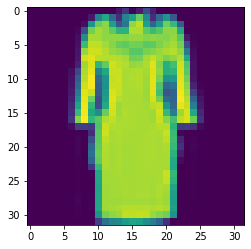

In [ ]:
def displayImage(index):
  k=train_set.__getitem__(index)
  r=k[0].reshape(32,32)
  plt.imshow(r)

displayImage(4)

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 32, 32])

2


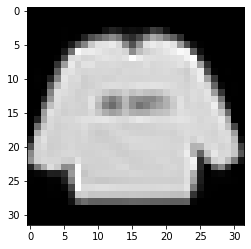

In [ ]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [ ]:
class block(nn.Module):
  def __init__(self,in_channels,out_channels,identity_downsample=None,stride=1):
    super(block,self).__init__()
    self.expansion=4
    self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0 )
    self.bn1=nn.BatchNorm2d(out_channels)

    self.conv2=nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1 )
    self.bn2=nn.BatchNorm2d(out_channels)

    self.conv3=nn.Conv2d(out_channels,out_channels*self.expansion,kernel_size=1,stride=1,padding=0)
    self.bn3=nn.BatchNorm2d(out_channels*self.expansion)
    self.relu=nn.ReLU()

    self.identity_downsample=identity_downsample

  def forward(self,x):
    identity=x
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.bn2(x)
    x=self.relu(x)
    x=self.conv3(x)
    x=self.bn3(x)

    if self.identity_downsample is not None:
      identity=self.identity_downsample(identity)
    
    x+=identity
    x=self.relu(x)
    return x


In [ ]:
class ResNet(nn.Module):
  def __init__(self,block,layers,image_channels,num_classes):
    super(ResNet,self).__init__()
    self.in_channels=64
    self.conv1=nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3)
    self.bn1=nn.BatchNorm2d(64)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    #ResNet layers
    self.layer1=self._make_layer(block,layers[0],out_channels=64,stride=1)
    self.layer2=self._make_layer(block,layers[1],out_channels=128,stride=2)
    self.layer3=self._make_layer(block,layers[2],out_channels=256,stride=2)
    self.layer4=self._make_layer(block,layers[0],out_channels=512,stride=2)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(512*4,num_classes)

  def forward(self,x):
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.maxpool(x)

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

    x=self.avgpool(x)
    x=x.reshape(x.shape[0],-1)

    x=self.fc(x)
    return x




  def _make_layer(self,block,num_residual_blocks,out_channels,stride):
    identity_downsample=None
    layers=[]
    if stride!=1 or self.in_channels!=out_channels*4:
      identity_downsample=nn.Sequential(
          nn.Conv2d(self.in_channels,out_channels*4,kernel_size=1,stride=stride),
          nn.BatchNorm2d(out_channels*4)
      )
      layers.append(block(self.in_channels,out_channels,identity_downsample,stride))
      self.in_channels=out_channels*4
      
      for i in range(num_residual_blocks-1):
        layers.append(block(self.in_channels,out_channels))
      return nn.Sequential(*layers)


In [ ]:
def ResNet50(img_channels=1,num_classes=1000):
  return ResNet(block,[3,4,6,3],img_channels,num_classes)

def ResNet101(img_channels=3,num_classes=1000):
  return ResNet(block,[3,4,23,3],img_channels,num_classes)

def ResNet152(img_channels=3,num_classes=1000):
  return ResNet(block,[3,4,36,3],img_channels,num_classes)
  



In [ ]:
model=ResNet50()
model.to(device)

error=nn.CrossEntropyLoss()

learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 32, 32))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 32, 32))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.8276155591011047, Accuracy: 78.7699966430664%
Iteration: 1000, Loss: 0.33564266562461853, Accuracy: 87.18000030517578%
Iteration: 1500, Loss: 0.26419153809547424, Accuracy: 87.93000030517578%
Iteration: 2000, Loss: 0.23903127014636993, Accuracy: 89.66999816894531%
Iteration: 2500, Loss: 0.24158382415771484, Accuracy: 89.63999938964844%
Iteration: 3000, Loss: 0.22185878455638885, Accuracy: 89.2699966430664%


In [ ]:
iteration_list = torch.tensor(iteration_list, device = 'cpu')
loss_list = torch.tensor(loss_list, device = 'cpu')
accuracy_list=torch.tensor(accuracy_list, device = 'cpu')

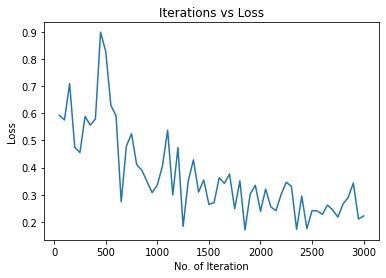

In [ ]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

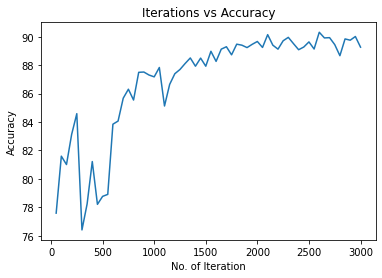

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [ ]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 78.70%
Accuracy of Trouser: 98.90%
Accuracy of Pullover: 76.50%
Accuracy of Dress: 90.90%
Accuracy of Coat: 92.70%
Accuracy of Sandal: 97.90%
Accuracy of Shirt: 71.00%
Accuracy of Sneaker: 90.90%
Accuracy of Bag: 97.70%
Accuracy of Ankle Boot: 97.50%


In [ ]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [ ]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.78      0.83      0.80     60000
           1       0.98      0.98      0.98     60000
           2       0.82      0.77      0.79     60000
           3       0.86      0.89      0.88     60000
           4       0.77      0.83      0.80     60000
           5       0.96      0.94      0.95     60000
           6       0.68      0.61      0.64     60000
           7       0.93      0.93      0.93     60000
           8       0.96      0.97      0.96     60000
           9       0.94      0.95      0.95     60000

    accuracy                           0.87    600000
   macro avg       0.87      0.87      0.87    600000
weighted avg       0.87      0.87      0.87    600000


